# Results of the OptoSim super-resolution project

### Setup

In [95]:
import results as rs 
import importlib
importlib.reload(rs)

notebook_name = 'Results'

In [2]:
import glob
import os
import pickle
import sys
import json
import h5py


import numpy as np
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm


import optosim

from optosim.settings import DATA_DIR, MODEL_DIR
from optosim.settings import PROJECT_DIR

from optosim.simulation.event_reader import EventReader, show_data
from optosim.super_resolution.model import SuperResolutionModel
from optosim.super_resolution.model import create_datasets
import optosim.super_resolution.model_utils as model_utils
from optosim.model_train import read_events, get_model_parameters

from optosim.super_resolution.model_utils import (
    reshape_data,
    weighted_average_estimator,
    downsample_heatmaps_to_dimensions,
    mse,
    r_squared,
)


In [3]:
print("DATA_DIR: ", DATA_DIR)
print("MODEL_DIR: ", MODEL_DIR)

DATA_DIR:  /data/xenon/optosim/data/
MODEL_DIR:  /data/xenon/optosim/models/


In [4]:
SAVE_FIGURES = True

In [5]:
def save_figure(fig, filename, notebook_name=notebook_name, save=SAVE_FIGURES):
    """Save a matplotlib figure in the figures folder of the project.
    The prefix of the figure filename needs to be the same as the notebook filename
    The figures folder is located in PROJECT_DIR/notbooks/figures

    Args:
        fig (matplotlib.figure.Figure): Matplotlib figure to save
        filename (str): Filename of the notebook
        prefix (str, optional): Prefix of the figure filename. Defaults to None.
        folder (str, optional): Folder to save the figure in. Defaults to "figures".
    """

    if save:
        prefix = notebook_name.lower()

        folder = "figures"

        # Save one png and one pdf version of the figure
        fig.savefig(os.path.join(PROJECT_DIR, "notebook", folder, f"{prefix}-{filename}.png"), dpi=300, bbox_inches="tight")
        fig.savefig(os.path.join(PROJECT_DIR, "notebook", folder, f"{prefix}-{filename}.pdf"), dpi=300, bbox_inches="tight")

        print(f"Figure saved as {prefix}_{filename}")

    else:
        print(f"Figure NOT saved as {prefix}_{filename}")

    

In [6]:
show_data(DATA_DIR)

Found 8 subdirectories
Subdirectories:
['mc0006', 'mc0007', 'mc0010', 'mc0011', 'mc0012', 'mc0020', 'mc0021', 'mc0022']


,subdir,detector,nevents,nphoton_per_event,scatter,experimental_scatter_model,radius,energy_scale
0,mc0006,XAMS,10000,"[1000, 25000]",NaN,NaN,3.2,NaN
1,mc0007,XENONnT,10000,"[1000, 25000]",NaN,NaN,65.0,NaN
2,mc0010,XAMS,10000,"[100, 100000]",True,True,3.2,NaN
3,mc0011,XAMS,10000,"[100, 100000]",True,False,3.2,NaN
4,mc0012,XAMS,10000,"[100, 100000]",False,NaN,3.2,NaN
5,mc0020,XAMS,10000,"[100, 100000]",True,True,3.2,linear
6,mc0021,XAMS,5000,"[100, 100000]",True,False,3.2,linear
7,mc0022,XAMS,5000,"[100, 100000]",False,NaN,3.2,linear


### Read the simulation data

In [80]:
#############
#  Settings #
#############

test_run_id = "mc0012"
train_run_id = "mc0010"
nmax = 20_000
normalise = False


suffix = "_normalise" if normalise else ""
id = f"-train_{train_run_id}{suffix}-test_{test_run_id}"
id

'-train_mc0010-test_mc0012'

In [81]:

files = glob.glob(os.path.join(DATA_DIR, test_run_id) + '/*.hd*')
files = files[::-1]
print(f"Found {len(files)} files")

Found 100 files


In [82]:
with h5py.File(files[0], "r") as f:
    config = json.loads(f.attrs.get("config"))
config

{'detector': 'XAMS',
 'nevents': 10000,
 'nphoton_per_event': [100, 100000],
 'photon_zgen': 0.5,
 'geometry': {'type': 'cylinder',
  'radius': 3.2,
  'ztop': 1.2,
  'zliq': 0.0,
  'zbot': -6.7,
  'ptfe_zmin': -5.32,
  'ptfe_zmax': -0.25},
 'npmt_xy': 2,
 'pmt': {'type': 'square', 'size': 2.54, 'ndivs': 10},
 'scatter': False,
 'set_experimental_scatter_model': False,
 'data_type_version': 2.0}

In [83]:
nevents = config["nevents"]
radius = config['pmt']['size']
cylinder_radius = config['geometry']['radius']
npmts_low = config["npmt_xy"]
npmts_high = config["pmt"]['ndivs']*npmts_low

print(f"Number of events: {nevents}")
print(f"Radius: {radius} cm")
print(f"Cylinder radius: {cylinder_radius} cm")
print(f"Number of low resolution PMTs: {npmts_low}")
print(f"Number of high resolution PMTs: {npmts_high}")


Number of events: 10000
Radius: 2.54 cm
Cylinder radius: 3.2 cm
Number of low resolution PMTs: 2
Number of high resolution PMTs: 20


In [84]:
# Choose number of files based on nevents and nmax. Each file has nevents events, i want to get nmax
nfiles = int(np.ceil(nmax / nevents))
print(f"Total number of files is {len(files)}")
print(f"Total number of events is {len(files)*nevents}")
print(f"-----------------------------")
print(f"Number of files to read: {nfiles}")
print(f"Number of events to read: {nfiles*nevents} ( {nfiles/len(files)*100:.2f}% )")

Total number of files is 100
Total number of events is 1000000
-----------------------------
Number of files to read: 2
Number of events to read: 20000 ( 2.00% )


In [85]:
from optosim.simulation.event_reader import EventReader
e = EventReader(files[:nfiles])

EventReader initialized with:
  number of files:  2
  number of events:  20000
  configuration:  {'detector': 'XAMS', 'nevents': 10000, 'nphoton_per_event': [100, 100000], 'photon_zgen': 0.5, 'geometry': {'type': 'cylinder', 'radius': 3.2, 'ztop': 1.2, 'zliq': 0.0, 'zbot': -6.7, 'ptfe_zmin': -5.32, 'ptfe_zmax': -0.25}, 'npmt_xy': 2, 'pmt': {'type': 'square', 'size': 2.54, 'ndivs': 10}, 'scatter': False, 'set_experimental_scatter_model': False, 'data_type_version': 2.0}


In [86]:
e.data_dict.keys()

dict_keys(['fine_bot', 'fine_top', 'nphoton', 'number', 'pmt_bot', 'pmt_top', 'true_position'])

In [87]:

true_pos = e.data_dict['true_position']
fine_top = e.data_dict['fine_top']
top = e.data_dict['pmt_top']
n_true_photon = e.data_dict['nphoton']    
n_detected_photon = np.sum(top, axis=(1,2))
# transpose every element of top. So not top itself but every element of top
top = np.array([np.transpose(t) for t in top])
fine_top = np.array([np.transpose(t) for t in fine_top])



Figure saved as results_test_data_with_tpc


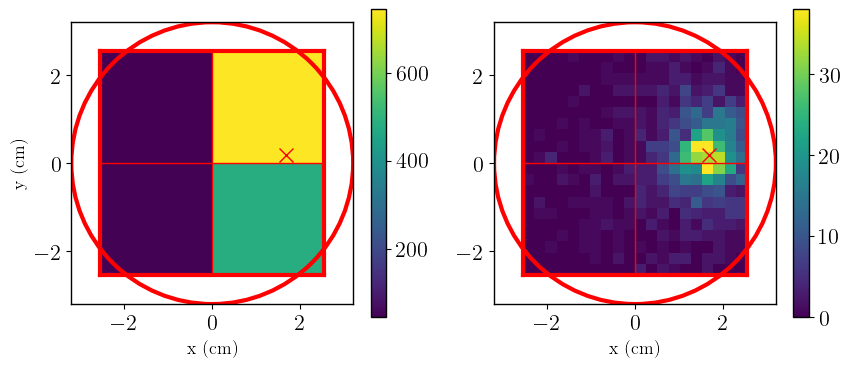

In [88]:
num = 0
fig, ax = rs.plot_test_data(top, fine_top, true_pos, num, r=radius)
save_figure(fig, f"test_data_with_tpc")
plt.show()

### Make test data

In [89]:
# create train and test sets
y = np.asarray(fine_top)
X = np.asarray(top)
pos = [pos[:2] for pos in true_pos] # depth is not used

if normalise:
    # Normalise X and y such that sum is 1
    print("Normalising X and y such that sum is 1")
    X = [x / np.sum(x) for x in X]
    y = [y / np.sum(y) for y in y]

X_train, y_train, pos_train, X_test, y_test, pos_test = create_datasets(X, y, pos, train_fraction=0)

print(f"Getting {len(X_test)} test events")

Getting 20000 test events


### Get the models

In [90]:
# Weighted average estimator

wa_pred = weighted_average_estimator(X_test, r=radius)
wa_mse = mse(pos_test, wa_pred)
wa_r2 = r_squared(pos_test, wa_pred)

In [91]:
# Utils

# Let's make a function to read the models from the pickle files
def read_model(model_name):

    print(f"Reading model {model_name}")
    model_file = os.path.join(MODEL_DIR, train_run_id, model_name)
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
    return model

# Define a function to get the number of pmts from a filename like model_2x2_mc0006.pkl
def get_pmts_from_filename(filename):
    return int(filename.split("_")[1].split('x')[0])

# Define a function to get the run id from a filename like model_2x2_mc0006.pkl
def get_filename_from_pmts(pmts_per_dim, train_run_id, suffix):
    return f"model_{pmts_per_dim}x{pmts_per_dim}_{train_run_id}{suffix}.pkl"


In [92]:


# Define list of models to read
read_all_models = True

if read_all_models:
    models_to_read = [os.path.basename(x) for x in glob.glob(os.path.join(MODEL_DIR, train_run_id, f"*{train_run_id}*.pkl"))]
    
    # I want to select only the models relative to the suffix
    models_to_read = [x for x in models_to_read if suffix in x]
    if suffix == "":
        # I want to read only the models without suffix
        models_to_read = [x for x in models_to_read if "norm" not in x]

    models_to_read = sorted(models_to_read, key=lambda x: int(get_pmts_from_filename(x)))
else: 
    # Read only these files
    pmts_per_dim_to_load = [2,3,4,5,6,7,8,9,10,11,12]
    models_to_read = [get_filename_from_pmts(pmts_per_dim, run_id) for pmts_per_dim in pmts_per_dim_to_load]


# Let's read all the files
models = {}
for model_name in models_to_read:
    models[model_name] = read_model(model_name)

# Let's make a function to predict the position of the events


Reading model model_2x2_mc0010.pkl
Reading model model_3x3_mc0010.pkl
Reading model model_4x4_mc0010.pkl
Reading model model_5x5_mc0010.pkl
Reading model model_6x6_mc0010.pkl
Reading model model_7x7_mc0010.pkl
Reading model model_8x8_mc0010.pkl
Reading model model_9x9_mc0010.pkl
Reading model model_10x10_mc0010.pkl
Reading model model_11x11_mc0010.pkl
Reading model model_12x12_mc0010.pkl
Reading model model_13x13_mc0010.pkl
Reading model model_14x14_mc0010.pkl
Reading model model_15x15_mc0010.pkl
Reading model model_16x16_mc0010.pkl
Reading model model_17x17_mc0010.pkl
Reading model model_18x18_mc0010.pkl
Reading model model_19x19_mc0010.pkl
Reading model model_20x20_mc0010.pkl


In [93]:
# Make a result dictionary with the results for each model

results = {}

for model_name, model in models.items():
    print(f"Predicting with model {model_name}", end=": ")

    _pmts = get_pmts_from_filename(model_name)
    res = model.evaluate(X_test, pos_test, normalise=normalise)

    results[model_name] = {}
    results[model_name]['PMTs'] = _pmts
    results[model_name]['pred'] = res['pred']
    results[model_name]['pred_heatmap'] = res['pred_heatmap']
    results[model_name]['MSE'] = res['MSE']
    results[model_name]['R^2'] = res['R^2']

    print(f"MSE: {res['MSE']:.2f} - PMTs {_pmts}")


Predicting with model model_2x2_mc0010.pkl: MSE: 0.28 - PMTs 2
Predicting with model model_3x3_mc0010.pkl: MSE: 38.46 - PMTs 3
Predicting with model model_4x4_mc0010.pkl: MSE: 43.72 - PMTs 4
Predicting with model model_5x5_mc0010.pkl: MSE: 259.86 - PMTs 5
Predicting with model model_6x6_mc0010.pkl: MSE: 193.56 - PMTs 6
Predicting with model model_7x7_mc0010.pkl: MSE: 110.72 - PMTs 7
Predicting with model model_8x8_mc0010.pkl: MSE: 413.20 - PMTs 8
Predicting with model model_9x9_mc0010.pkl: MSE: 583.14 - PMTs 9
Predicting with model model_10x10_mc0010.pkl: MSE: 18.00 - PMTs 10
Predicting with model model_11x11_mc0010.pkl: MSE: 410.06 - PMTs 11
Predicting with model model_12x12_mc0010.pkl: MSE: 124.31 - PMTs 12
Predicting with model model_13x13_mc0010.pkl: MSE: 63.30 - PMTs 13
Predicting with model model_14x14_mc0010.pkl: MSE: 341.21 - PMTs 14
Predicting with model model_15x15_mc0010.pkl: MSE: 51.98 - PMTs 15
Predicting with model model_16x16_mc0010.pkl: MSE: 199.86 - PMTs 16
Predicting 

## Let's make nice plots

- 2d histogram of true x - x vs true y - y :: resolution of best model\\
- 1d histogram of true r - r :: resolution of best model\\
- comparison of resolutions (MSE/R2) for different models\\
- error correlation with position\\

We decide that the best model is 5x5

model: model_2x2_mc0010.pkl           --PMTS: 2 -- RSE: 0.2834 -- R^2: 0.8899
model: model_3x3_mc0010.pkl           --PMTS: 3 -- RSE: 38.4572 -- R^2: -13.9377
model: model_4x4_mc0010.pkl           --PMTS: 4 -- RSE: 43.7188 -- R^2: -15.9814
model: model_5x5_mc0010.pkl           --PMTS: 5 -- RSE: 259.8579 -- R^2: -99.9350
model: model_6x6_mc0010.pkl           --PMTS: 6 -- RSE: 193.5604 -- R^2: -74.1835
model: model_7x7_mc0010.pkl           --PMTS: 7 -- RSE: 110.7248 -- R^2: -42.0081
model: model_8x8_mc0010.pkl           --PMTS: 8 -- RSE: 413.2030 -- R^2: -159.4979
model: model_9x9_mc0010.pkl           --PMTS: 9 -- RSE: 583.1430 -- R^2: -225.5066
model: model_10x10_mc0010.pkl         --PMTS: 10 -- RSE: 18.0001 -- R^2: -5.9917
model: model_11x11_mc0010.pkl         --PMTS: 11 -- RSE: 410.0630 -- R^2: -158.2783
model: model_12x12_mc0010.pkl         --PMTS: 12 -- RSE: 124.3074 -- R^2: -47.2840
model: model_13x13_mc0010.pkl         --PMTS: 13 -- RSE: 63.2986 -- R^2: -23.5867
model: model_14x14

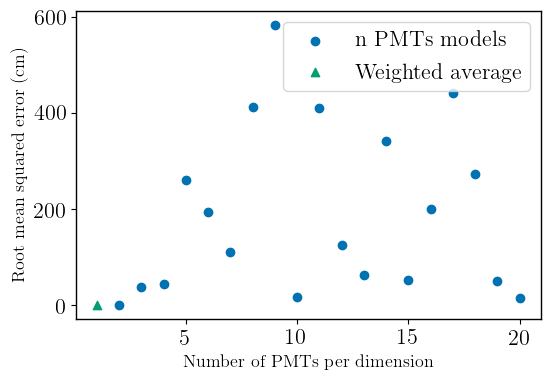

In [94]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse_scatter(results, wa_mse, figsize=(6, 4)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Get the first color of the color cycle from the style
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

    for i, model_name in enumerate(results.keys()):
        res = results[model_name]
        print(f"model: {model_name:<30} --PMTS: {res['PMTs']} -- RSE: {res['MSE']:.4f} -- R^2: {res['R^2']:.4f}")
        if i == 0:
            ax.scatter(res['PMTs'], res['MSE'], label='n PMTs models', color=color)
        else:
            ax.scatter(res['PMTs'], res['MSE'], c=color)

    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    ax.scatter(1, wa_mse, marker='^', color=color, label="Weighted average")

    ax.set_ylabel("Root mean squared error (cm)")
    ax.set_xlabel("Number of PMTs per dimension")
    # ax.set_axisbelow(True)
    # yaxis = ax.yaxis
    # yaxis.set_major_formatter(ticker.ScalarFormatter())
    # yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    # yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    # xaxis = ax.xaxis
    # xaxis.set_major_locator(ticker.MultipleLocator(5))
    # xaxis.set_minor_locator(ticker.MultipleLocator(1))
    # xaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.legend()

    return fig, ax

# Usage
fig, ax = plot_mse_scatter(results, wa_mse)
save_figure(fig, f"rmse_per_model{id}")


### Define comparison models

In [22]:
stupid = 2
great = 5
finest = 20

In [23]:
stupid_model_name = get_filename_from_pmts(stupid, train_run_id, suffix)
stupid_model = models[stupid_model_name]

great_model_name = get_filename_from_pmts(great, train_run_id, suffix)
great_model = models[great_model_name]

finest_model_name = get_filename_from_pmts(finest, train_run_id, suffix)
finest_model = models[finest_model_name]

print(f"Stupid model: {stupid_model_name}")
print(f"Great model: {great_model_name}")
print(f"Finest model: {finest_model_name}")

Stupid model: model_2x2_mc0010.pkl
Great model: model_5x5_mc0010.pkl
Finest model: model_20x20_mc0010.pkl


In [24]:
great_pred_pos = results[great_model_name]['pred']
stupid_pred_pos = results[stupid_model_name]['pred']
finest_pred_pos = results[finest_model_name]['pred']

_great_pmts = results[great_model_name]['PMTs']
_stupid_pmts = results[stupid_model_name]['PMTs']
_finest_pmts = results[finest_model_name]['PMTs']

print(f"Stupid model: {_stupid_pmts} PMTs")
print(f"Great model: {_great_pmts} PMTs")
print(f"Finest model: {_finest_pmts} PMTs")


Stupid model: 2 PMTs
Great model: 5 PMTs
Finest model: 20 PMTs


In [25]:
# Get the radius of the events
r = np.linalg.norm(pos_test, axis=1)

great_r_pred = np.linalg.norm(great_pred_pos, axis=1)
stupid_r_pred = np.linalg.norm(stupid_pred_pos, axis=1)
finest_model_r_pred = np.linalg.norm(finest_pred_pos, axis=1)


# Get the delta r
great_dr = great_r_pred - r
stupid_dr = stupid_r_pred - r
finest_dr = finest_model_r_pred - r
wa_dr = np.linalg.norm(wa_pred - pos_test, axis=1)

# Get the distance between the predicted and true positions
great_dist = np.linalg.norm(great_pred_pos - pos_test, axis=1)
stupid_model_dist = np.linalg.norm(stupid_pred_pos - pos_test, axis=1)
wa_dist = np.linalg.norm(wa_pred - pos_test, axis=1)
finest_model_dist = np.linalg.norm(finest_pred_pos - pos_test, axis=1)



Figure saved as results_xy_2dhist-train_mc0010-test_mc0010-2x2pmts


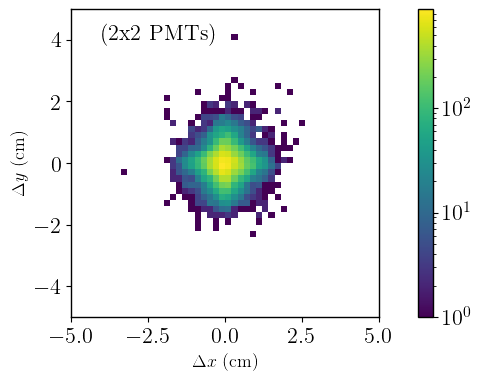

Figure saved as results_xy_2dhist-train_mc0010-test_mc0010-5x5pmts


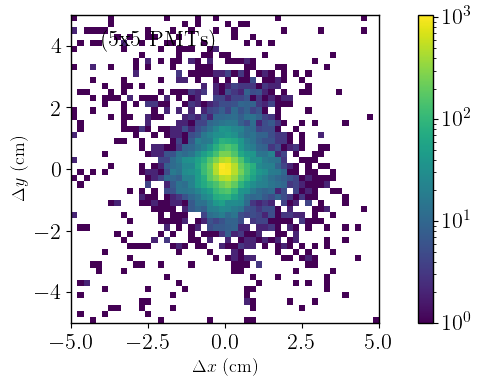

Figure saved as results_xy_2dhist-train_mc0010-test_mc0010-20x20pmts


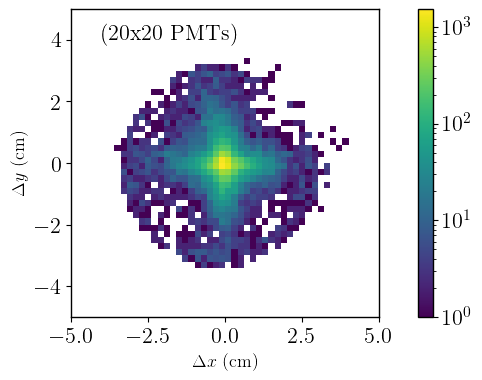

In [26]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_2d_histogram(true_pos, predicted_pos, model_name, model_details, bins=50, range=((-5,5),(-5,5))):
    """
    Plot a 2D histogram for the deviation in x and y positions.

    Parameters:
    - true_pos: True positions.
    - predicted_pos: Predicted positions from the model.
    - model_name: Name of the model.
    - model_details: Additional details about the model (e.g., number of PMTs).
    - bins: Number of bins for the histogram.
    - range: Range for the histogram.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    plt.hist2d(
        predicted_pos[:,0] - true_pos[:,0],
        predicted_pos[:,1] - true_pos[:,1],
        bins=bins,
        range=range,
        norm=LogNorm(),
    )

    plt.xlabel("$\Delta x$ (cm)")
    plt.ylabel("$\Delta y$ (cm)")
    plt.colorbar()
    ax.set_aspect(1)
    plt.text(range[0][0] + 0.1*(range[0][1]-range[0][0]), range[1][1] - 0.1*(range[1][1]-range[1][0]), f"({model_details})", fontsize=16)

    return fig, ax

# Usage
for model in [stupid_model_name, great_model_name, finest_model_name]:
    _pmts = results[model]['PMTs']
    fig, ax = plot_2d_histogram(pos_test, results[model]['pred'], model, f"{_pmts}x{_pmts} PMTs")
    save_figure(fig, f"xy_2dhist{id}-{_pmts}x{_pmts}pmts")
    plt.show()


Figure saved as results_dr_histogram-train_mc0010-test_mc0010
Figure saved as results_dist_histogram-train_mc0010-test_mc0010


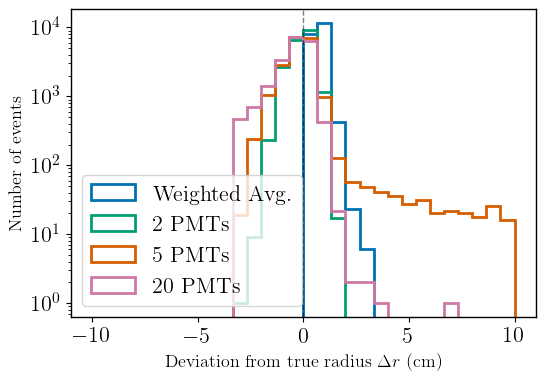

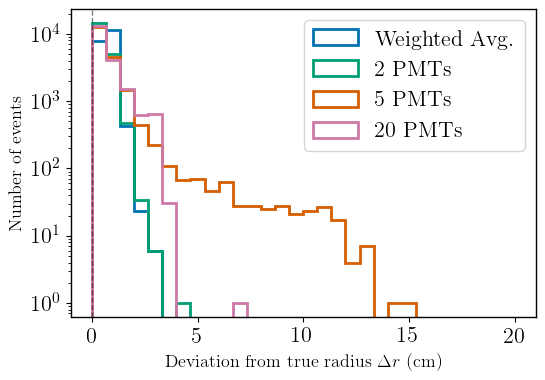

In [27]:
import matplotlib.pyplot as plt

def plot_histogram(data_list, labels, xlabel, ylabel, range=None, n_bins=30, log_scale=False):
    """
    Plot histograms for a list of data.

    Parameters:
    - data_list: List of data arrays to plot.
    - labels: Labels for each data array.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - range: Range for the histogram.
    - n_bins: Number of bins.
    - log_scale: Whether to use a logarithmic scale on the y-axis.
    - save_path: Path to save the figure (optional).
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    for data, label in zip(data_list, labels):
        plt.hist(
            data,
            bins=n_bins,
            range=range,
            label=label,
            histtype="step",
            linewidth=2,
        )

    plt.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    if log_scale:
        plt.yscale('log')

    return fig, ax

# Usage
values = [wa_dr, stupid_dr, great_dr, finest_dr]
labels = ["Weighted Avg.", f"{_stupid_pmts} PMTs", f"{_great_pmts} PMTs", f"{_finest_pmts} PMTs"]

fig, ax = plot_histogram(
    values, 
    labels, 
    "Deviation from true radius $\Delta r$ (cm)", 
    "Number of events", 
    range=(-10,10), 
    log_scale=True
)
save_figure(fig, f"dr_histogram{id}")


values = [wa_dist, stupid_model_dist, great_dist, finest_model_dist]
labels = ["Weighted Avg.", f"{_stupid_pmts} PMTs", f"{_great_pmts} PMTs", f"{_finest_pmts} PMTs"]

fig, ax = plot_histogram(
    values, 
    labels, 
    "Deviation from true radius $\Delta r$ (cm)", 
    "Number of events", 
    range=(0,20), 
    log_scale=True
)
save_figure(fig, f"dist_histogram{id}")




In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def compute_statistics(X, true_data, predicted_data_list, bins, statistic_func):
    """
    Compute statistics for a given property.
    
    Parameters:
    - true_data: The true values of the property.
    - predicted_data_list: A list of predicted values from different models.
    - bins: Binning for the x-axis data.
    - statistic_func: Function to compute the desired property (e.g., dr, xy_dist).
    
    Returns:
    - binned_statistic_list: A list of binned statistics for each model.
    """
    binned_statistic_list = []
    
    for predicted_data in predicted_data_list:
        diff = statistic_func(true_data, predicted_data)
        mean, _, _ = stats.binned_statistic(X, diff, statistic='mean', bins=bins)
        std, _, _ = stats.binned_statistic(X, diff, statistic='std', bins=bins)
        binned_statistic_list.append((mean, std))
        
    return binned_statistic_list

def plot_statistics(x_data, bins, binned_statistic_list, labels):
    """
    Plot the computed statistics.
    
    Parameters:
    - x_data: Data for the x-axis.
    - bins: Binning for the x-axis data.
    - binned_statistic_list: Output from compute_statistics.
    - labels: Labels for each model.
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    for (mean, std), label in zip(binned_statistic_list, labels):
        plt.plot(bins[:-1], mean, label=label, linewidth=2)
        try:
            plt.fill_between(bins[:-1], mean - std, mean + std, alpha=0.2)
        except:
            pass
    plt.legend()

    return fig, ax

# Define your statistic functions
def func_dr(true_pos, pred_pos):
    _r = np.linalg.norm(true_pos, axis=1)
    _pred_r = np.linalg.norm(pred_pos, axis=1)
    result = _pred_r - _r
    return result

def func_xy_dist(true_pos, pred_pos):
    return np.linalg.norm(pred_pos - true_pos, axis=1)



Figure saved as results_dr_vs_r-train_mc0010-test_mc0010
Figure saved as results_dxy_vs_r-train_mc0010-test_mc0010
Figure saved as results_dxy_vs_ph-train_mc0010-test_mc0010


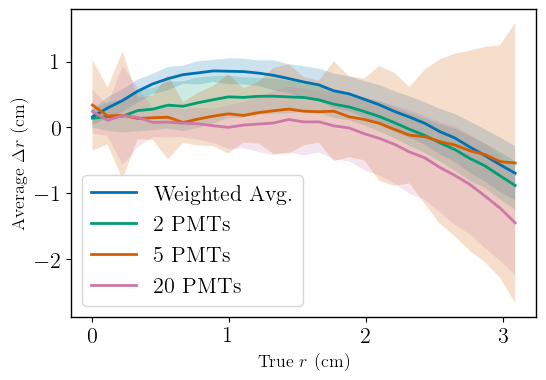

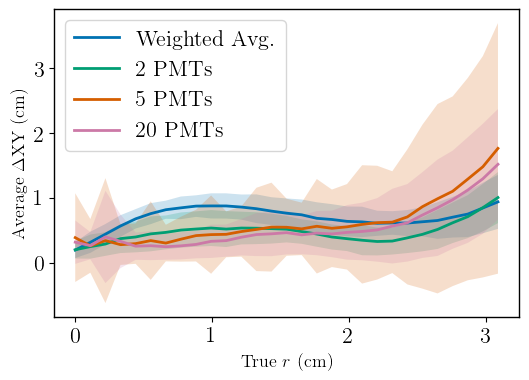

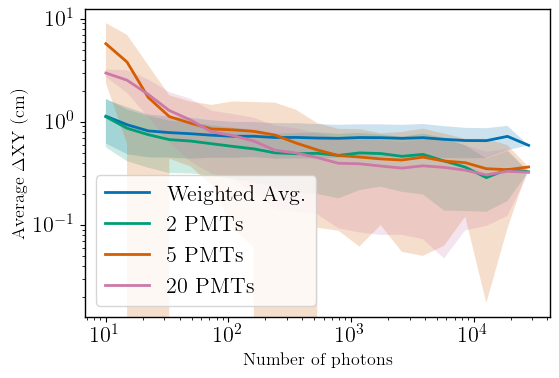

In [30]:

labels = ["Weighted Avg.", f"{_stupid_pmts} PMTs", f"{_great_pmts} PMTs", f"{_finest_pmts} PMTs"]


bins = np.linspace(0, 3.2, 30)
r = np.linalg.norm(pos_test, axis=1)

statistics = compute_statistics(r, pos_test, [wa_pred, stupid_pred_pos, great_pred_pos, finest_pred_pos], bins, func_dr)
fig, ax = plot_statistics(r, bins, statistics, labels)
plt.xlabel("True $r$ (cm)")
plt.ylabel("Average $\Delta r$ (cm)")
save_figure(fig, f"dr_vs_r{id}") 

statistics = compute_statistics(r, pos_test, [wa_pred, stupid_pred_pos, great_pred_pos, finest_pred_pos], bins, func_xy_dist)
fig, ax = plot_statistics(r, bins, statistics, labels)
plt.xlabel("True $r$ (cm)")
plt.ylabel("Average $\Delta$XY (cm)")
save_figure(fig, f"dxy_vs_r{id}") 


bins = np.logspace(1, 6, 30)
statistics = compute_statistics(n_detected_photon, pos_test, [wa_pred, stupid_pred_pos, great_pred_pos, finest_pred_pos], bins, func_xy_dist)
fig, ax = plot_statistics(n_detected_photon, bins, statistics, labels)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of photons")
plt.ylabel("Average $\Delta$XY (cm)")
save_figure(fig, f"dxy_vs_ph{id}") 

Plotting model model_2x2_mc0010.pkl, 2 PMTs
Figure saved as results_xy_2dhist_with_weights-train_mc0010-test_mc0010-2x2pmts


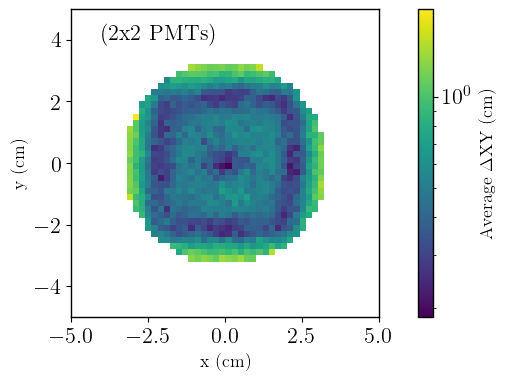

Plotting model model_5x5_mc0010.pkl, 5 PMTs
Figure saved as results_xy_2dhist_with_weights-train_mc0010-test_mc0010-5x5pmts


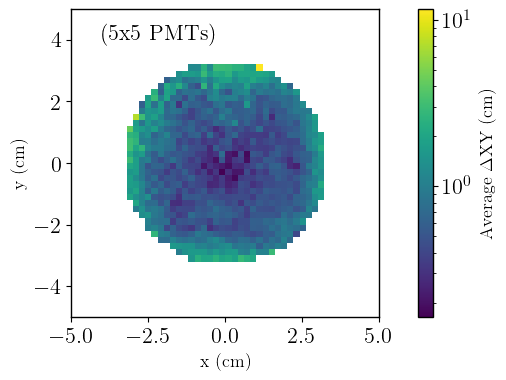

Plotting model model_20x20_mc0010.pkl, 20 PMTs
Figure saved as results_xy_2dhist_with_weights-train_mc0010-test_mc0010-20x20pmts


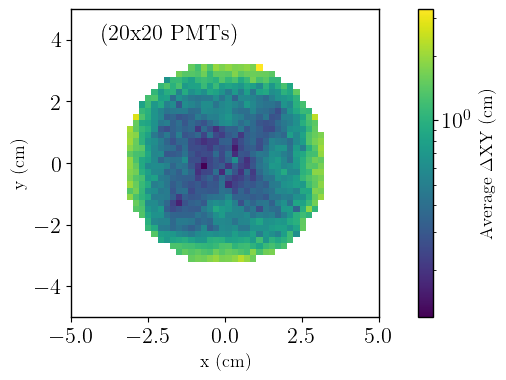

In [32]:
# I want a 2d histogram, x on x and y on y, the weights are the distance from the true position. Do it as a function where i can pass the three models stupid great and finest

def plot_2d_histogram_with_weights(true_pos, predicted_pos, model_name, model_details, bins=50, range=((-5,5),(-5,5))):
    """
    Plot a 2D histogram for the deviation in x and y positions.

    Parameters:
    - true_pos: True positions.
    - predicted_pos: Predicted positions from the model.
    - model_name: Name of the model.
    - model_details: Additional details about the model (e.g., number of PMTs).
    - bins: Number of bins for the histogram.
    - range: Range for the histogram.
    """
    # Calculate the average xy distance for each bin
    xy_dist = np.linalg.norm(predicted_pos - true_pos, axis=1)
    H, xedges, yedges = np.histogram2d(
        true_pos[:,0],
        true_pos[:,1],
        bins=bins,
        range=range,
    )
    H_dist, xedges, yedges = np.histogram2d(
        true_pos[:,0],
        true_pos[:,1],
        bins=bins,
        range=range,
        weights=xy_dist,
    )
    H_norm = np.divide(H_dist, H, out=np.zeros_like(H_dist), where=H!=0)

    # Plot the histogram
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    plt.imshow(
        H_norm.T,
        interpolation="nearest",
        origin="lower",
        extent=[range[0][0], range[0][1], range[1][0], range[1][1]],
        norm=LogNorm(),
    )

    plt.xlabel("x (cm)")
    plt.ylabel("y (cm)")
    plt.colorbar(label="Average $\Delta$XY (cm)")
    ax.set_aspect(1)
    plt.text(range[0][0] + 0.1*(range[0][1]-range[0][0]), range[1][1] - 0.1*(range[1][1]-range[1][0]), f"({model_details})", fontsize=16)

    return fig, ax

# Usage
for model in [stupid_model_name, great_model_name, finest_model_name]:
    _pmts = results[model]['PMTs']
    print(f"Plotting model {model}, {_pmts} PMTs")
    fig, ax = plot_2d_histogram_with_weights(pos_test, results[model]['pred'], model, f"{_pmts}x{_pmts} PMTs")
    save_figure(fig, f"xy_2dhist_with_weights{id}-{_pmts}x{_pmts}pmts")
    plt.show()

## Check one by one

In [ ]:
# check if data is ok

from matplotlib.colors import LogNorm

# import make_axes_locatable
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_one_event(test_heat, predicted_heat, true_heat, true_downsampled_heat, predicted_pos, true_pos, wa_pos):


    # have the y shared between the plots
    fig, ax = plt.subplots(1, 4, figsize=(18, 4), sharey=True)

    ax = ax.ravel()

    values = [
        test_heat,
        predicted_heat,
        true_downsampled_heat,
        true_heat,
    ]

    titles = [
        "Test event",
        "Predicted event",
        "True downsampled",
        "True event",
    ]

    # find min and max of all the values[i]
    vmin = np.min([np.min(v) for v in values])
    vmax = np.max([np.max(v) for v in values])

    for i in range(len(values)):

        im = ax[i].imshow(
            values[i],
            interpolation="nearest",
            origin="lower",
            extent=[-r, r, -r, r],
            # set the same vmax and vmin for all the plots
            # vmin=vmin,
            # vmax=vmax,
        )

        ax[i].set_title(titles[i])

        markersize = 15

        ax[i].plot(
            true_pos[0],
            true_pos[1],
            marker="X",
            markersize=markersize,
            color="red",
            label="true position",
        )

        ax[i].plot(
            predicted_pos[0],
            predicted_pos[1],
            marker="^",
            markersize=markersize,
            color="cyan",
            label="predicted position",
        )

        ax[i].plot(
            wa_pos[0],
            wa_pos[1],
            marker="d",
            markersize=markersize,
            color="m",
            label="Weighted average",
        )

        ax[i].set_xlabel("x (cm)")

        # Add a small text with the total amount of hits
        # so sum all the values in the multi-dimensional array
        ax[i].text(
            -1.5,
            4.2,
            f"Total hits: {np.sum(values[i]):.1f}",
            fontsize=12,
            color="k",
        )

        # add a colorbar right next to the plot without space in between
        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    ax[0].set_ylabel("y (cm)")

    # put the legend above the subplots 
    # centralised with respect to the figure
    ax[-1].legend(
        bbox_to_anchor=(-1.5, 1.5), 
        loc='upper center', 
        ncol=3, 
        fontsize=16
    )

    plt.show()


In [90]:
# Get the number of hits for each event
n_hits = np.sum(X_test, axis=(1, 2))
n_hits[:10]

array([13232, 21900,  8699, 15687, 12898,  9771,  2163,  1431,  9589,
       16602])

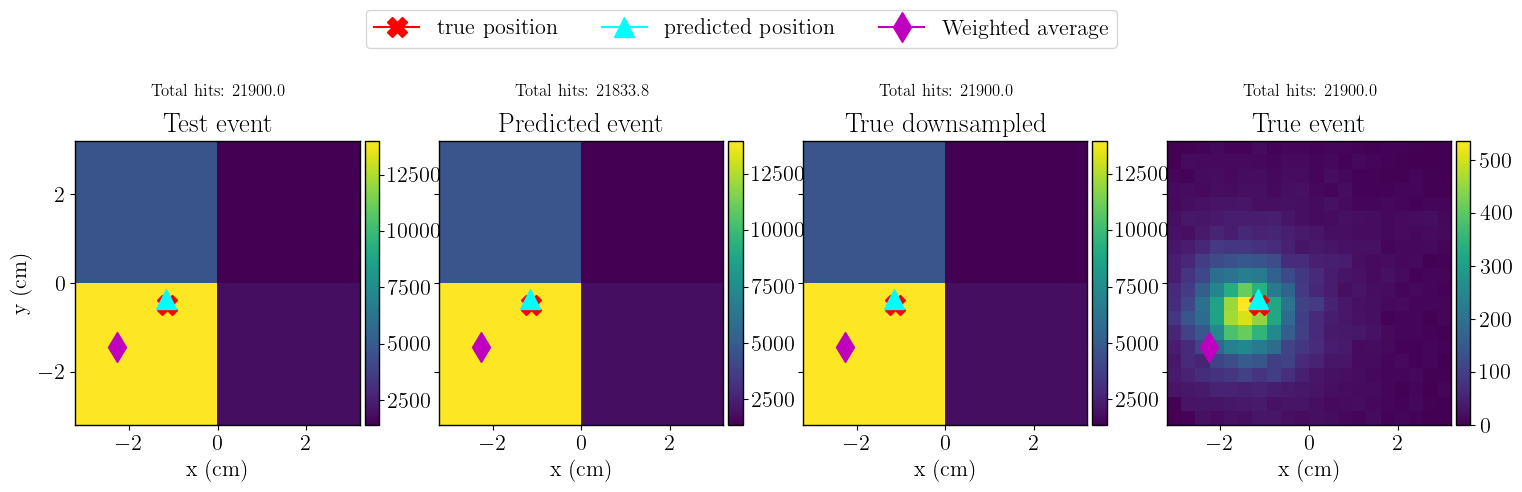

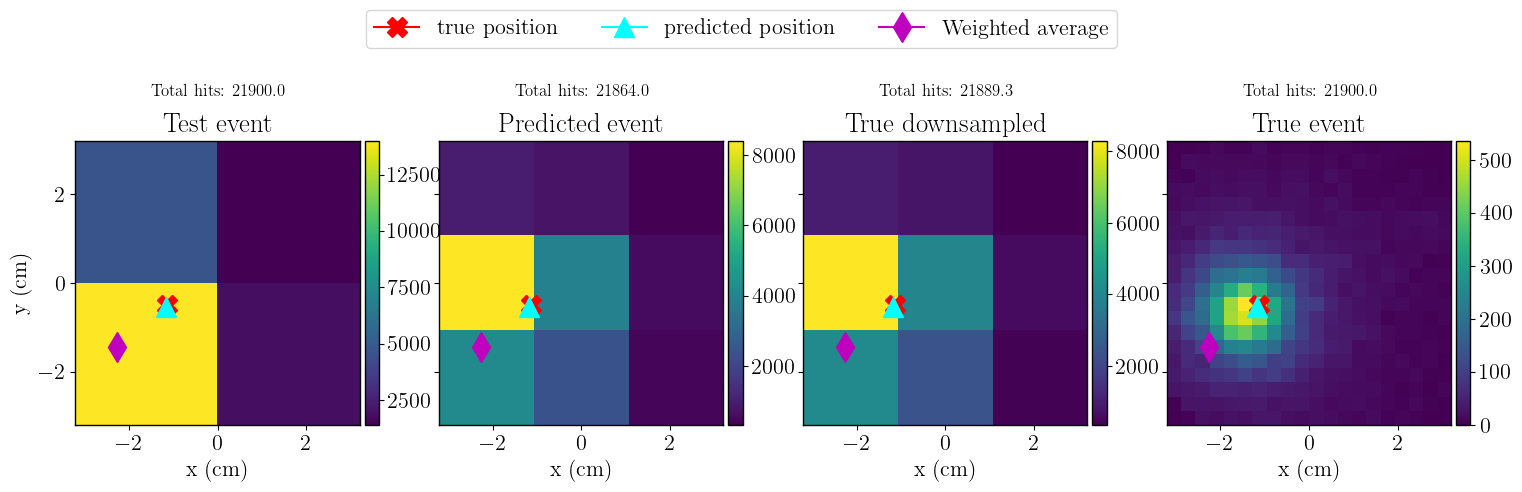

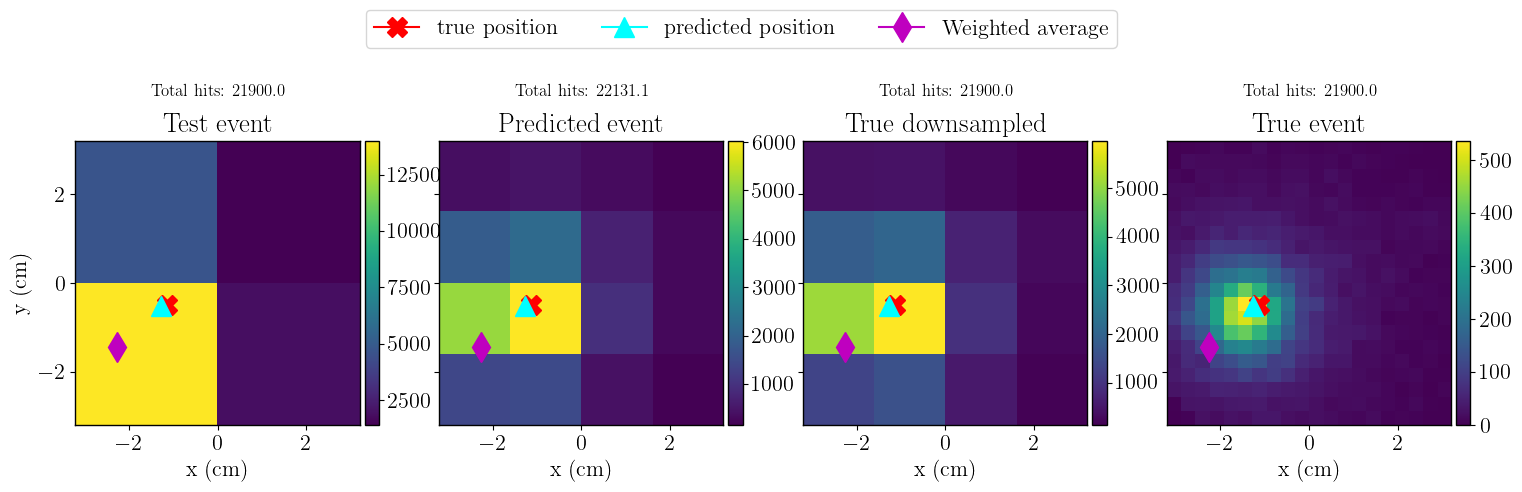

In [91]:
n_pmts = 10
i = 1
r = 3.2

# for n_pmts in range(2,20) one every 3

for n_pmts in [2, 3, 4]:

    model = models[get_filename_from_pmts(n_pmts, train_run_id, suffix)]

    one_test_heat = X_test[i]

    one_true_pos = pos_test[i]
    one_true_heat = y_test[i]
    one_true_downsampled_heat = downsample_heatmaps_to_dimensions(np.array([one_true_heat, ]), n_pmts, n_pmts)[0]

    one_pred_heat, one_pred_pos = model.predict(np.array([X_test[i], ]))
    one_pred_heat = one_pred_heat[0]
    one_pred_heat = one_pred_heat.reshape(n_pmts,n_pmts)
    one_pred_pos = one_pred_pos[0]

    one_wa_pos = weighted_average_estimator(np.array([one_test_heat, ]), r=r)[0]

    plot_one_event(
        one_test_heat, 
        one_pred_heat, 
        one_true_heat, 
        one_true_downsampled_heat, 
        one_pred_pos, 
        one_true_pos, 
        one_wa_pos
    )

In [92]:
# Now i would like to make a figure in which i do the plot_one_event but for 5 different models. So basically every model a row, and in each row 4 columns, one for each plot_one_event


event_i = 5

def plot_one_event_together(event_i, r=3.2):
    
    n_pmts_list = [2, 3, 4]

    fig, ax = plt.subplots(len(n_pmts_list), 4, figsize=(18, 20), sharey=True)

    for j, n_pmts in enumerate(n_pmts_list):

        print(n_pmts)
        model = models[get_filename_from_pmts(n_pmts, train_run_id, suffix)]

        one_test_heat = X_test[event_i]
        one_true_pos = pos_test[event_i]
        one_true_heat = y_test[event_i]

        one_true_downsampled_heat = downsample_heatmaps_to_dimensions(np.array([one_true_heat, ]), n_pmts, n_pmts)[0]

        one_pred_heat, one_pred_pos = model.predict(np.array([one_test_heat, ]))
        one_pred_heat = one_pred_heat[0]
        one_pred_pos = one_pred_pos[0]

        one_pred_heat = one_pred_heat.reshape(n_pmts,n_pmts)

        one_wa_pos = weighted_average_estimator(np.array([one_test_heat, ]), r=r)[0]

        values = [
            one_test_heat,
            one_pred_heat,
            one_true_downsampled_heat,
            one_true_heat,
        ]

        titles = [
            f"Test event (2x2)",
            f"Predicted event ({n_pmts}x{n_pmts})",
            f"True downsampled ({n_pmts}x{n_pmts})",
            f"True event (20x20)",
        ]

        # find min and max of all the values[i]
        vmin = np.min([np.min(v) for v in values])
        vmax = np.max([np.max(v) for v in values])

        for i in range(len(values)):

            im = ax[j, i].imshow(
                values[i],
                interpolation="nearest",
                origin="lower",
                extent=[-r, r, -r, r],
                # set the same vmax and vmin for all the plots
                # vmin=vmin,
                # vmax=vmax,
            )

            ax[j, i].set_title(titles[i])

            markersize = 15

            ax[j, i].plot(
                one_true_pos[0],
                one_true_pos[1],
                marker="X",
                markersize=markersize,
                color="red",
                label="true position",
            )

            ax[j, i].plot(
                one_pred_pos[0],
                one_pred_pos[1],
                marker="^",
                markersize=markersize,
                color="cyan",
                label="predicted position",
            )

            ax[j, i].plot(
                one_wa_pos[0],
                one_wa_pos[1],
                marker="d",
                markersize=markersize,
                color="m",
                label="Weighted average",
            )

            ax[j, i].set_xlabel("x (cm)")

            # Add a small text with the total amount of hits
            # so sum all the values in the multi-dimensional array
            # let's move this text in a small frame in the bottom right of the plot

            ax[j,i].text(
                1.1,
                -4.4,
                f"Tot. hits: {np.sum(values[i]):.1f}",
                fontsize=14,
                color="k",
                bbox=dict(
                    facecolor='white',
                    edgecolor='black',
                    boxstyle='round'
                )
            )

            # add a colorbar right next to the plot without space in between
            divider = make_axes_locatable(ax[j,i])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)

            # ax[j,i].set_xlim(-r,r)
            # ax[j,i].set_ylim(-r,r)

        ax[j, 0].set_ylabel("y (cm)")

    # put the legend above the subplots 
    # centralised with respect to the figure
    ax[0, 3].legend(
        bbox_to_anchor=(-1.5, 1.35), 
        loc='upper center', 
        ncol=3, 
        fontsize=16
    )

    
    plt.show()

        

2
3
4


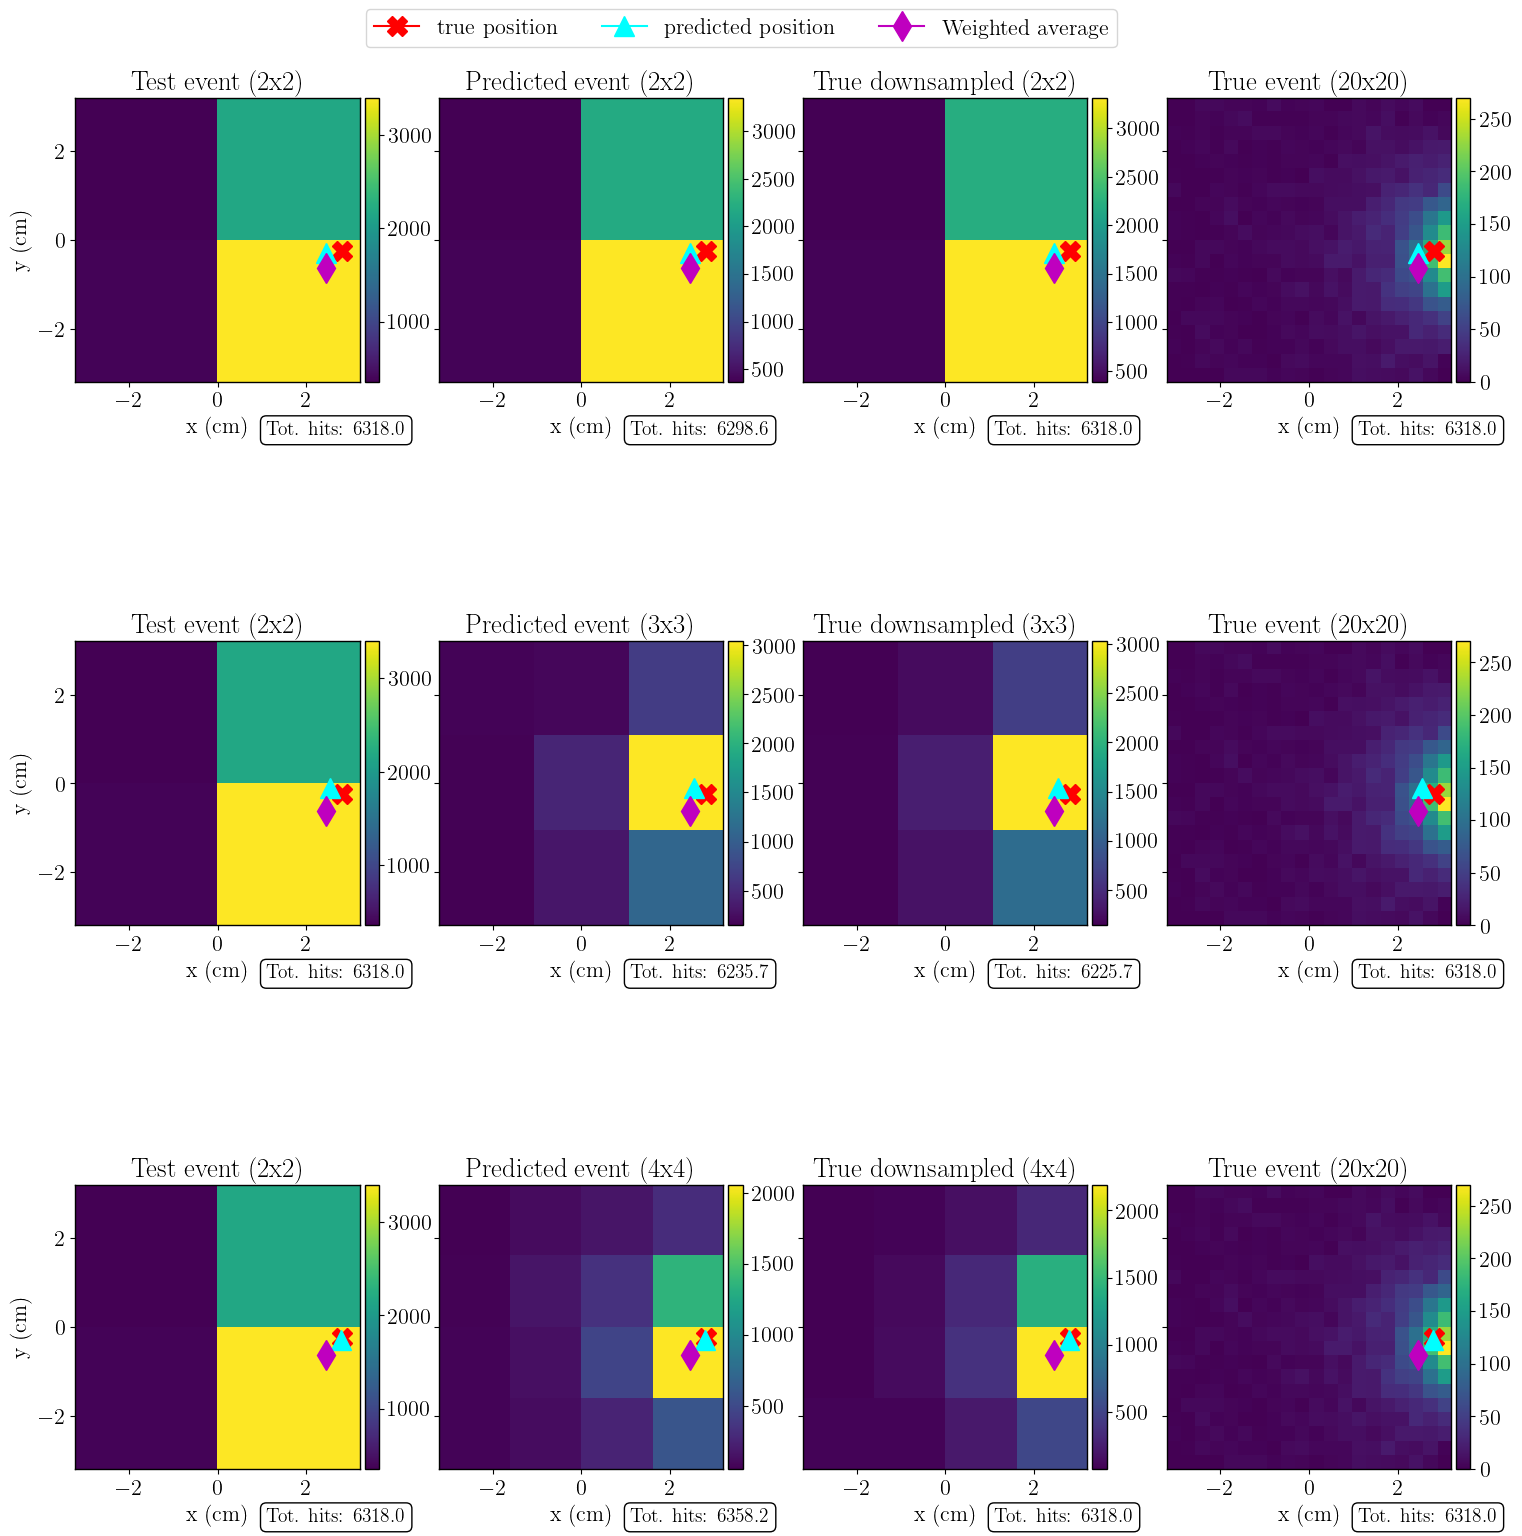

In [93]:
plot_one_event_together(487)

## Loss curve

Plotting loss curve for model model_2x2_mc0020.pkl


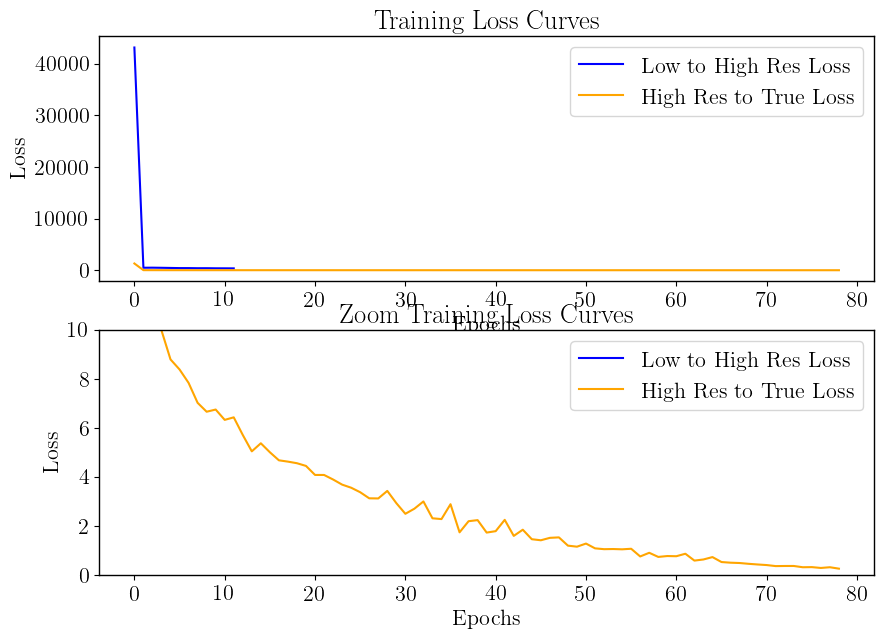

Plotting loss curve for model model_3x3_mc0020.pkl


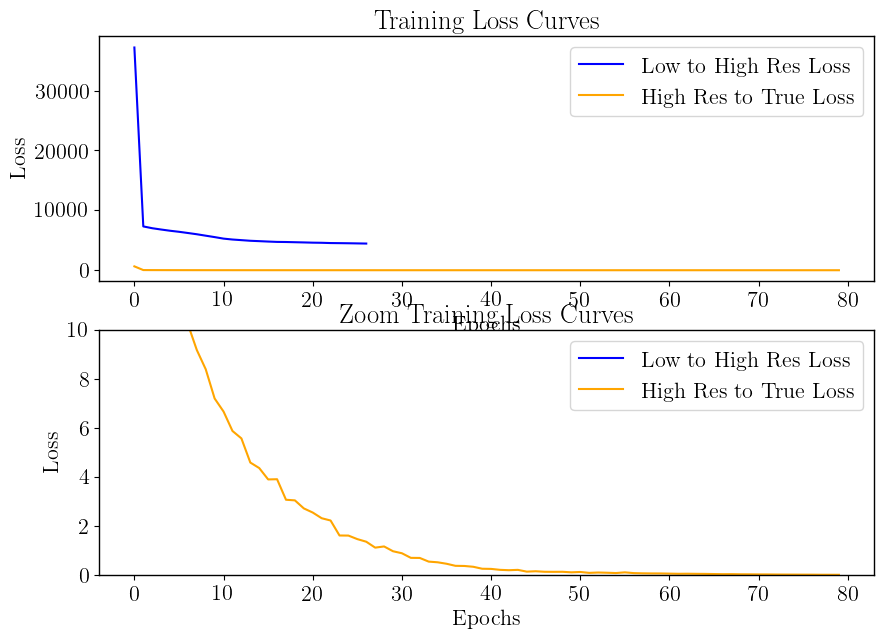

Plotting loss curve for model model_4x4_mc0020.pkl


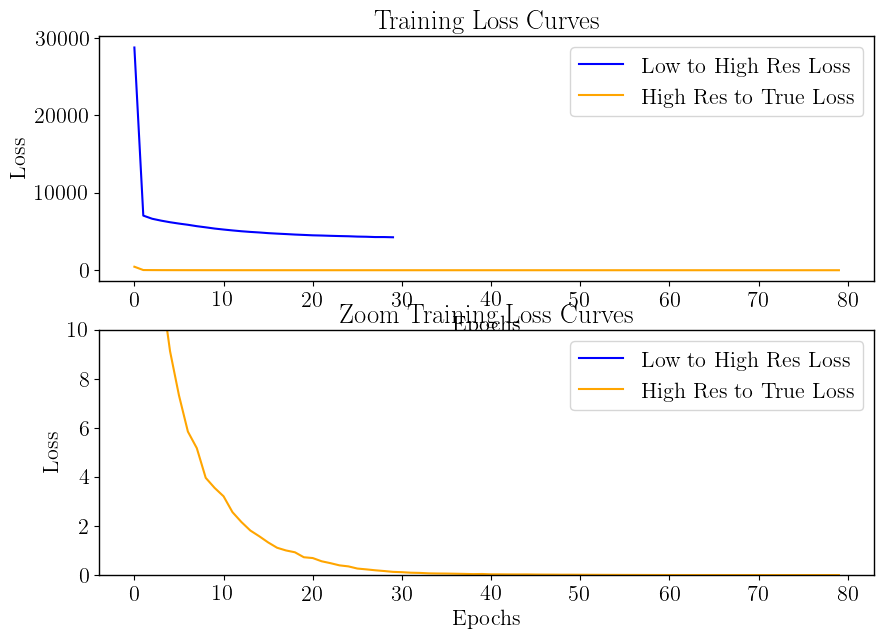

Plotting loss curve for model model_5x5_mc0020.pkl


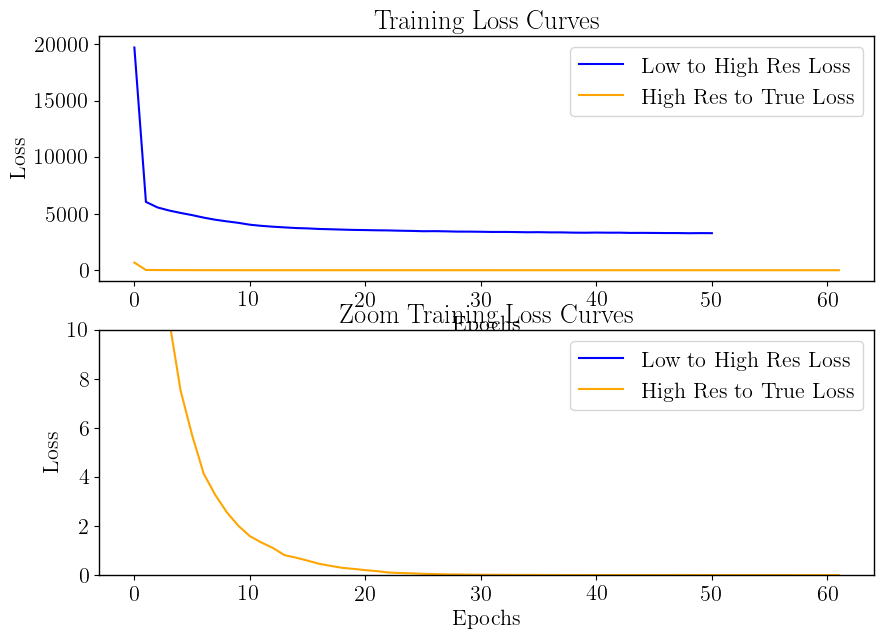

Plotting loss curve for model model_6x6_mc0020.pkl


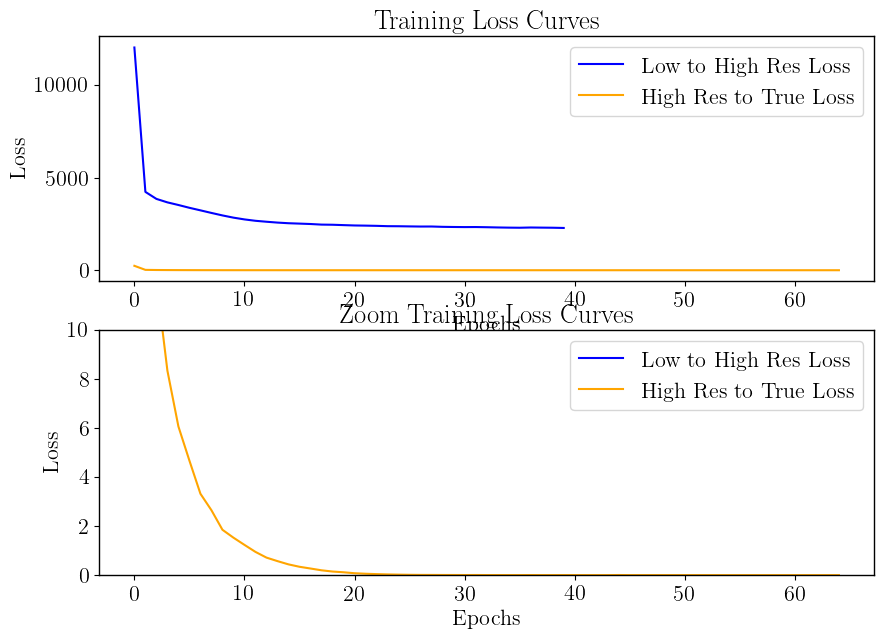

Plotting loss curve for model model_7x7_mc0020.pkl


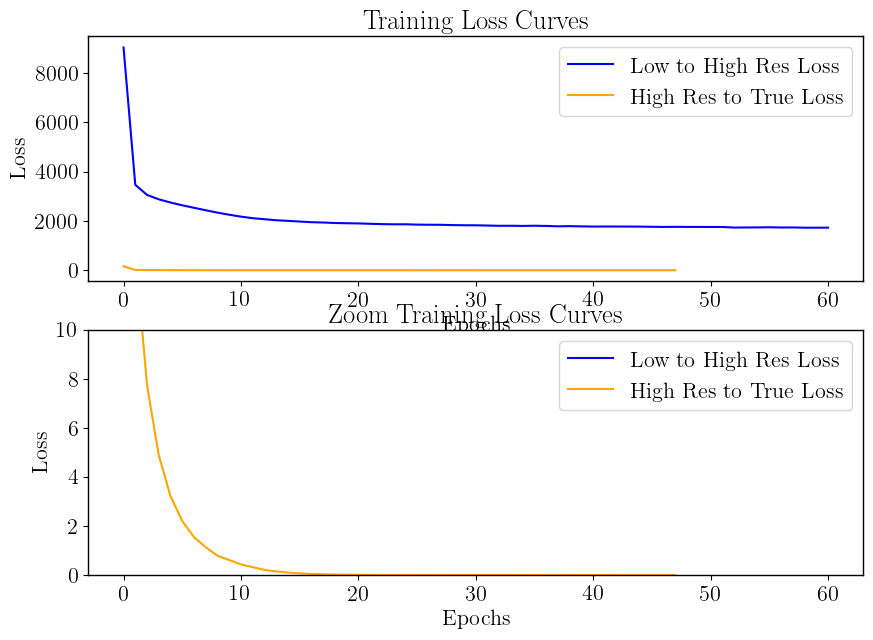

Plotting loss curve for model model_8x8_mc0020.pkl


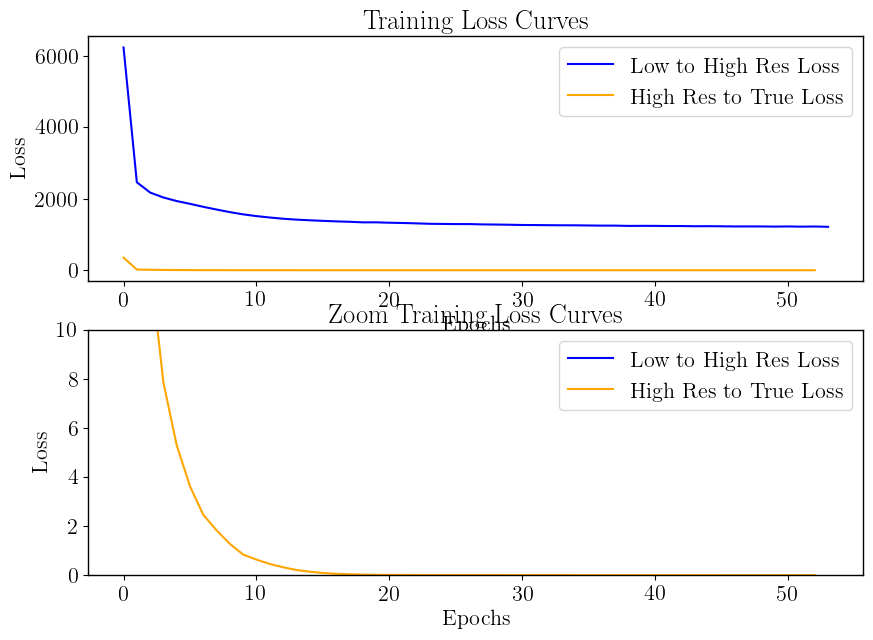

Plotting loss curve for model model_9x9_mc0020.pkl


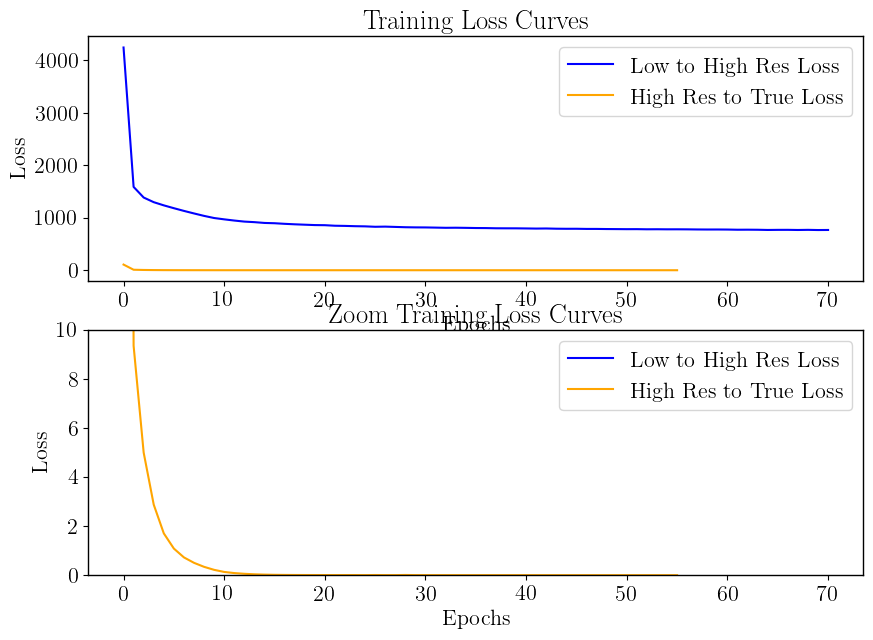

Plotting loss curve for model model_10x10_mc0020.pkl


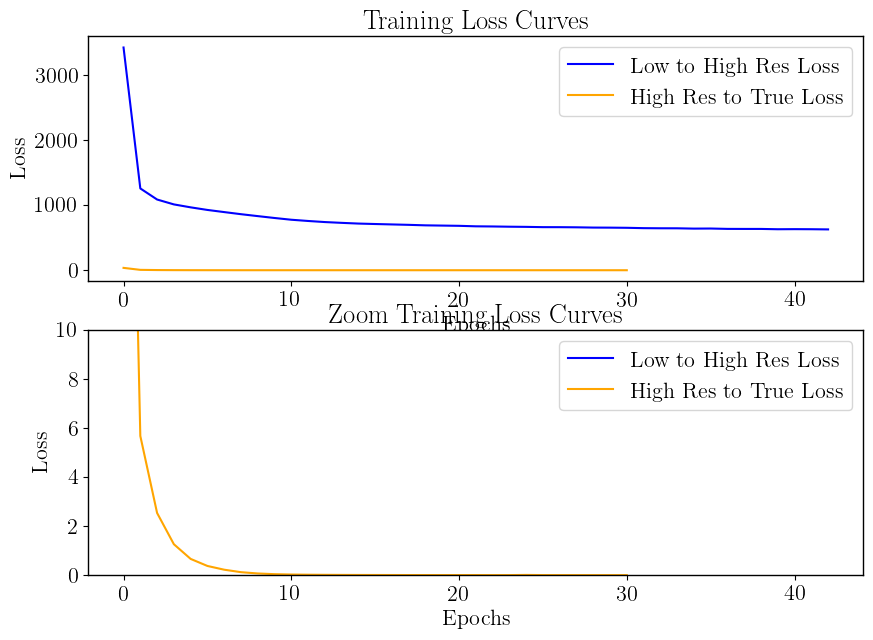

In [88]:
for model_name, model in models.items():
    print(f"Plotting loss curve for model {model_name}")
    loss = model.plot_loss_curve()

In [291]:
importlib.reload(rs)
r = rs.Results(
    test_run_id='mc0020', 
    train_run_id='mc0020', 
    nmax=20_000, 
    normalise=False
)

Initialising results for test run mc0020 and train run mc0020
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Number of events per file: 10000
Radius: 2.54 cm
Cylinder radius: 3.2 cm
Number of low resolution PMTs: 2
Number of high resolution PMTs: 20
Total number of files is 80
Total number of events is 800000
---------------------------------------
Number of files to read: 2
Number of events to read: 20000 ( 2.50% )
---------------------------------------


In [292]:
X_test, y_test, pos_test = r.get_data()

EventReader initialized with:
  number of files:  2
  number of events:  20000
  configuration:  {'detector': 'XAMS', 'nevents': 10000, 'nphoton_per_event': [100, 100000], 'energy_scale': 'linear', 'photon_zgen': 0.5, 'geometry': {'type': 'cylinder', 'radius': 3.2, 'ztop': 1.2, 'zliq': 0.0, 'zbot': -6.7, 'ptfe_zmin': -5.32, 'ptfe_zmax': -0.25}, 'npmt_xy': 2, 'pmt': {'type': 'square', 'size': 2.54, 'ndivs': 10}, 'scatter': True, 'experimental_scatter_model': True, 'data_type_version': 2.0}
---------------------------------------
Created test data with 20000 events
Made true_pos, fine_top, top, n_true_photon, n_detected_photon
Made X_test, y_test, pos_test


In [293]:
wa_pred, wa_mse, wa_r2 = r.get_wa_model()

Weighted average MSE: 0.58
Weighted average R2: 0.77


In [294]:
results = r.get_model_predictions()

Predicting with model model_2x2_mc0020.pkl: MSE: 0.17 - PMTs 2
Predicting with model model_3x3_mc0020.pkl: MSE: 0.12 - PMTs 3
Predicting with model model_4x4_mc0020.pkl: MSE: 0.13 - PMTs 4
Predicting with model model_5x5_mc0020.pkl: MSE: 0.10 - PMTs 5
Predicting with model model_6x6_mc0020.pkl: MSE: 0.12 - PMTs 6
Predicting with model model_7x7_mc0020.pkl: MSE: 0.11 - PMTs 7
Predicting with model model_8x8_mc0020.pkl: MSE: 0.11 - PMTs 8
Predicting with model model_9x9_mc0020.pkl: MSE: 0.12 - PMTs 9
Predicting with model model_10x10_mc0020.pkl: MSE: 0.12 - PMTs 10
Predicting with model model_11x11_mc0020.pkl: MSE: 0.11 - PMTs 11
Predicting with model model_12x12_mc0020.pkl: MSE: 0.12 - PMTs 12
Predicting with model model_13x13_mc0020.pkl: MSE: 0.14 - PMTs 13
Predicting with model model_14x14_mc0020.pkl: MSE: 0.11 - PMTs 14
Predicting with model model_15x15_mc0020.pkl: MSE: 0.11 - PMTs 15
Predicting with model model_16x16_mc0020.pkl: MSE: 0.15 - PMTs 16
Predicting with model model_17x17_

Figure NOT saved as results_rmse_per_model-train_mc0020-test_mc0020


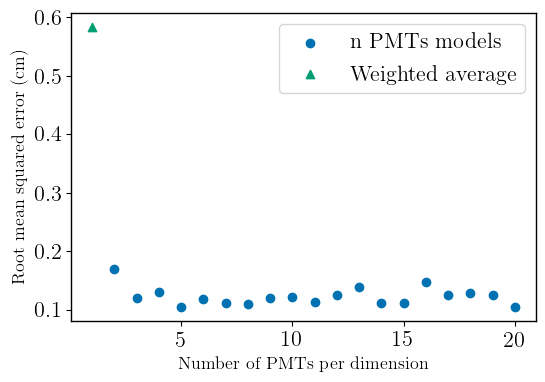

In [295]:
r.do_plot_mse_scatter()
plt.show()

In [296]:
r.get_comparison_model_predictions()

Stupid model: model_2x2_mc0020.pkl
Great model: model_5x5_mc0020.pkl
Finest model: model_20x20_mc0020.pkl


Figure NOT saved as results_xy_2dhist-train_mc0020-test_mc0020-2x2pmts


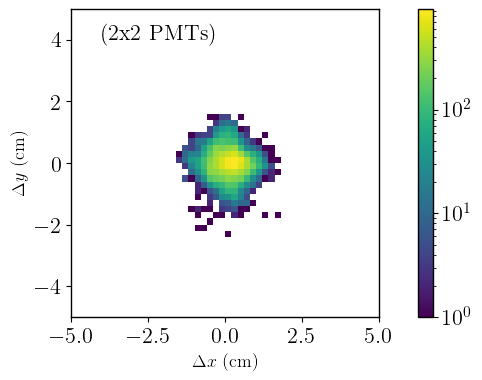

Figure NOT saved as results_xy_2dhist-train_mc0020-test_mc0020-5x5pmts


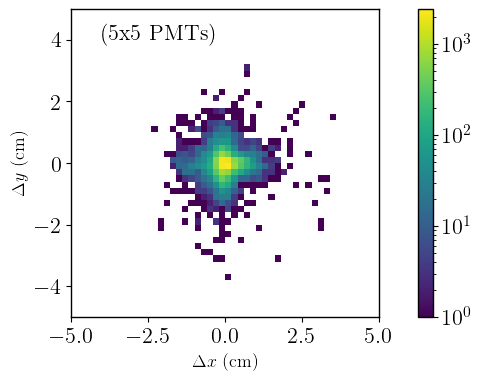

Figure NOT saved as results_xy_2dhist-train_mc0020-test_mc0020-20x20pmts


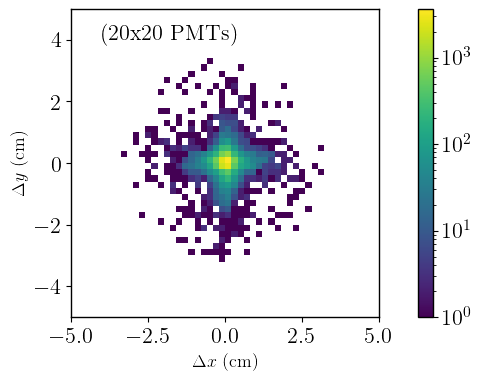

In [297]:
importlib.reload(rs)
r.do_plot_dx_dy_histogram()

Figure NOT saved as results_dr_histogram-train_mc0020-test_mc0020


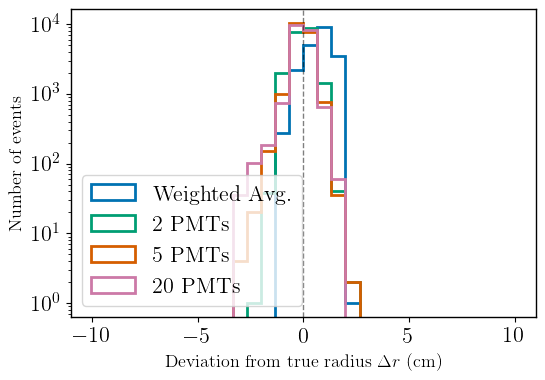

Figure NOT saved as results_dist_histogram-train_mc0020-test_mc0020


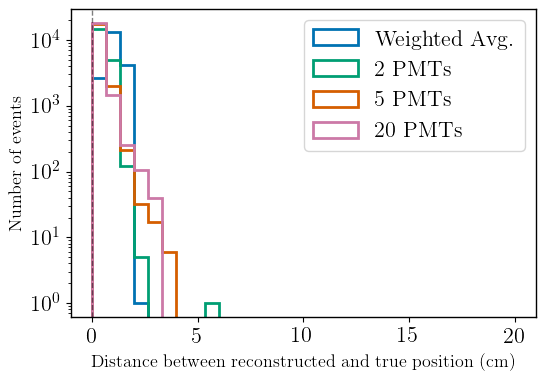

In [298]:
r.do_plot_1d_histogram('dr')
plt.show()

r.do_plot_1d_histogram('dist')
plt.show()

Figure NOT saved as results_dxy_vs_r-train_mc0020-test_mc0020


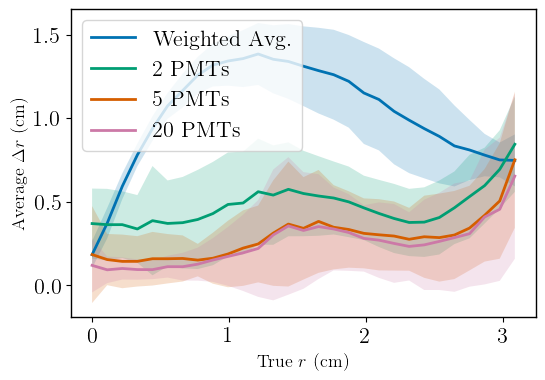

Figure NOT saved as results_dxy_vs_ph-train_mc0020-test_mc0020


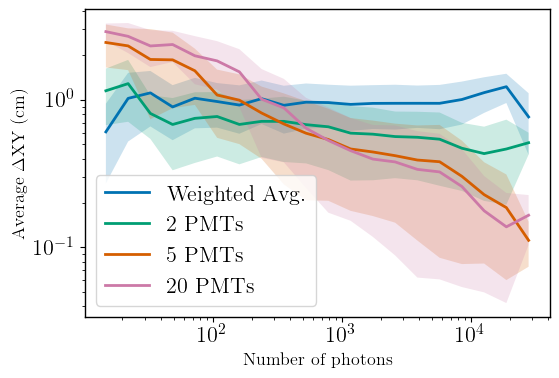

In [299]:
r.do_plot_statistics(which='r')
plt.show()

r.do_plot_statistics(which='ph')
plt.show()

Figure NOT saved as results_xy_2dhist_with_weights-train_mc0020-test_mc0020-2x2pmts


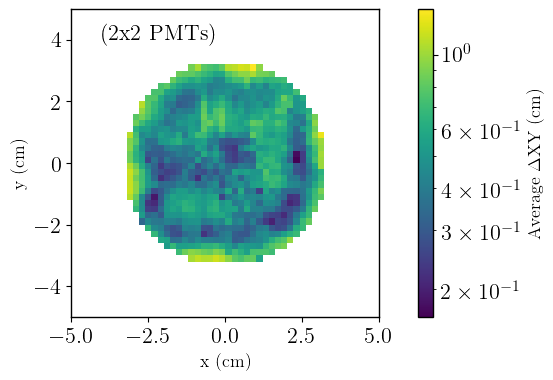

Figure NOT saved as results_xy_2dhist_with_weights-train_mc0020-test_mc0020-5x5pmts


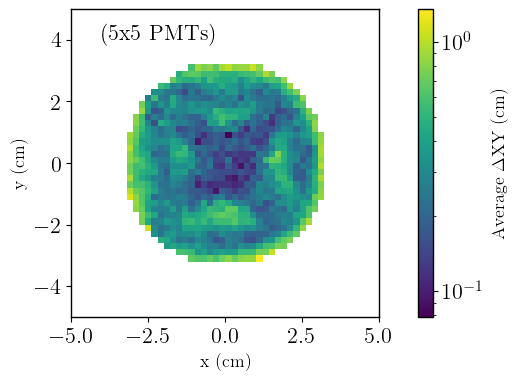

Figure NOT saved as results_xy_2dhist_with_weights-train_mc0020-test_mc0020-20x20pmts


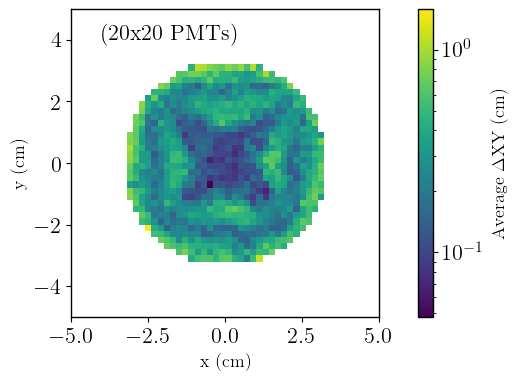

In [300]:
r.do_plot_2d_hist_with_weights()